In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [26]:
from typing import Dict, Type, Union, Tuple, Callable
import numpy as np
import pandas as pd

from desdeo_emo.population.Population import Population
from desdeo_emo.selection.SelectionBase import SelectionBase

import matplotlib.pyplot as plt
from desdeo_problem import DataProblem, MOProblem
from desdeo_problem.testproblems.TestProblems import test_problem_builder

from desdeo_emo.EAs import BaseEA
from numba import njit 
import hvwfg as hv
from desdeo_emo.selection.EnvironmentalSelection import EnvironmentalSelection
from desdeo_tools.scalarization import SimpleASF

# TODO: remember to sort import

from desdeo_emo.EAs.BaseIndicatorEA import BaseIndicatorEA
from desdeo_emo.EAs.IBEA import IBEA
from desdeo_emo.EAs.PBEA import PBEA, preference_indicator, distance_to_reference_point

from desdeo_tools.utilities.quality_indicator import epsilon_indicator, epsilon_indicator_ndims

In [27]:
#import warnings
#warnings.filterwarnings('ignore')

In [28]:
def preference_indicator2(reference_front: np.ndarray, front: np.ndarray, minasf, ref_point: np.ndarray, delta: float) -> float:
    """ Computes the preference-based quality indicator.

    Args:
        reference_front (np.ndarray): The reference front that the current front is being compared to.
        Should be an one-dimensional array.
        front (np.ndarray): The front that is compared. Should be one-dimensional array with the same shape as
        reference_front.
        ref_point (np.ndarray): The reference point should be same shape as front.
        delta (float): The spesifity delta allows to set the amplification of the indicator to be closer or farther 
        from the reference point. Smaller delta means that all solutions are in smaller range around the reference
        point.

    Returns:
        float: The factor by which the approximating front is worse than the reference front with respect to all
        objectives taking into account the reference point given and spesifity.
    """

    front_asf = SimpleASF(np.ones_like(front))
    norm = front_asf(front, reference_point=ref_point) + delta - minasf
    return epsilon_indicator(reference_front, front)/norm

# ZDT 

First get approx with IBEA

IBEA ideal [0.         0.33717218]


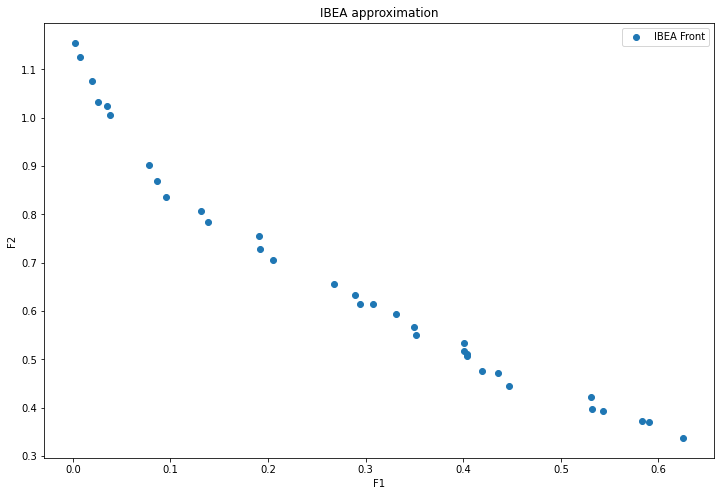

In [62]:
# start the problem
#%matplotlib notebook
problem_name = "ZDT1"
problem = test_problem_builder(problem_name)

# run ibea
# step 0. Let's start with rough approx
ib = IBEA(problem, population_size=32, n_iterations=10, n_gen_per_iter=100,total_function_evaluations=3000)
while ib.continue_evolution():
    ib.iterate()
individuals, objective_values = ib.end()
#print(objective_values)
# show some of the ibea pop somehow
print("IBEA ideal",ib.population.problem.ideal)
plt.scatter(x=objective_values[:,0], y=objective_values[:,1], label="IBEA Front")
plt.title(f"IBEA approximation")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.show()
# need to get the population
ini_pop = ib.population # so pbea doesn't get only the non dom pop members, and popsize stays the same

## Make PBEA object

In [63]:
delta = 0.1
evolver = PBEA(problem, interact=True, population_size=32, initial_population=ini_pop, 
               n_iterations=10, n_gen_per_iter=100, total_function_evaluations=1000, 
               indicator=preference_indicator2, delta=delta)

## Give preference information as a reference point

In [64]:
# ask for preference
pref, plot = evolver.requests()
print(pref.content['message'])

Provide preference point. TODO add more info


In [65]:
responses = np.asarray([[0.20, 0.7]])
pref.response = pd.DataFrame([responses[0]], columns=pref.content['dimensions_data'].columns)
pref, plot = evolver.iterate(pref)

# show the best solution closest to the reference point
i2, obj = evolver.end()
#obj = evolver.population.objectives # should one use all objectives here or only non dominated? achievement scalarizing should find the same solution in both cases 
# achievement function
dist, index = distance_to_reference_point(obj, responses[0])

print(f"Distance of best solution to the reference point: {dist}")
print(f"Values of best solution to the reference point: {obj[index]}")

message = (f"Current generation number:{evolver._current_gen_count}. "
           f"Is looping back recommended: {'Yes' if evolver.continue_evolution() else 'No'}"
           )
print(message)

Distance of best solution to the reference point: -0.058738388516471285
Values of best solution to the reference point: [0.1389552  0.64126161]
Current generation number:63. Is looping back recommended: No


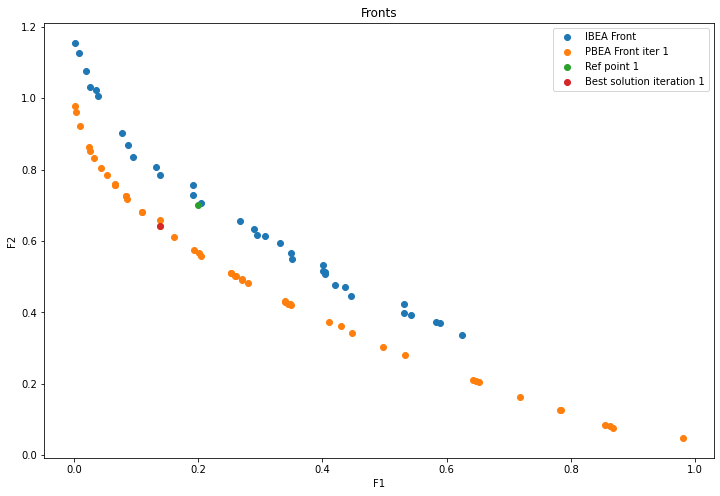

In [66]:
plt.rcParams['figure.figsize'] = [12, 8]

# should select small set of solutions to show to DM. For now we show all.
plt.scatter(x=objective_values[:,0], y=objective_values[:,1], label="IBEA Front")
plt.scatter(x=obj[:,0], y=obj[:,1], label="PBEA Front iter 1")
plt.scatter(x=responses[0][0], y=responses[0][1],  label="Ref point 1")    
plt.scatter(x=obj[index][0], y=obj[index][1], label="Best solution iteration 1")
plt.title(f"Fronts")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.show()

## Giving new preferences

In [67]:
evolver.delta = 0.01 # change delta
pref, plot = evolver.requests()
print(pref.content['message'])

Provide preference point. TODO add more info


In [68]:
responses = np.asarray([[.21, 0.5]])
pref.response = pd.DataFrame([responses[0]], columns=pref.content['dimensions_data'].columns)
pref, plot = evolver.iterate(pref)

# show the best solution closest to the reference point
i3, obj = evolver.end()
# achievement function
dist, index = distance_to_reference_point(obj, responses[0])

print(f"Distance of best solution to the reference point: {dist}")
print(f"Values of best solution to the reference point: {obj[index]}")

message = (f"Current generation number:{evolver._current_gen_count}. "
           f"Is looping back recommended: {'Yes' if evolver.continue_evolution() else 'No'}"
           )
print(message)

Distance of best solution to the reference point: 0.021942507352505053
Values of best solution to the reference point: [0.23194251 0.52007416]
Current generation number:126. Is looping back recommended: No


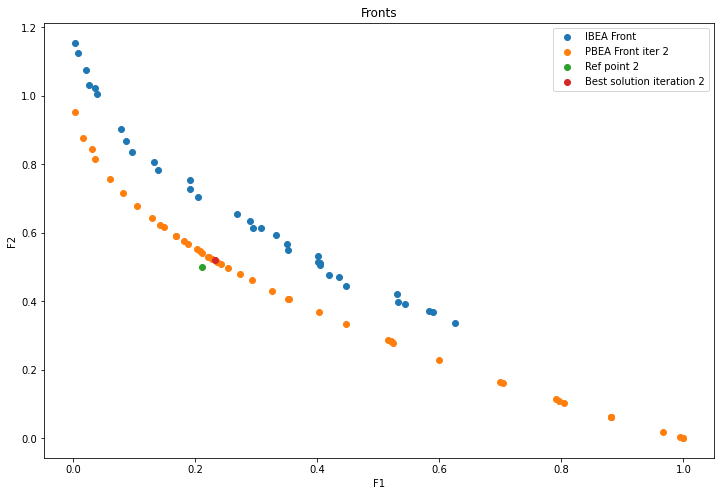

In [69]:
# should select small set of solutions to show to DM. For now we show all.
plt.scatter(x=objective_values[:,0], y=objective_values[:,1], label="IBEA Front")
plt.scatter(x=obj[:,0], y=obj[:,1], label="PBEA Front iter 2")
plt.scatter(x=responses[0][0], y=responses[0][1],  label="Ref point 2")    
plt.scatter(x=obj[index][0], y=obj[index][1], label="Best solution iteration 2")
plt.title(f"Fronts")
plt.xlabel("F1")
#plt.xlim(0,1.2)
#plt.ylim(0,1.2)
plt.ylabel("F2")
plt.legend()
plt.show()

# DTLZ

In [70]:
# start the problem

# I guess works good enough. Has some trouble
#problem_name = "DTLZ1" 
#problem = test_problem_builder(problem_name, n_of_variables=7, n_of_objectives=3)
    
problem_name = "DTLZ2" # works great
problem = test_problem_builder(problem_name, n_of_variables=12, n_of_objectives=3)

#problem_name = "DTLZ4" # needs 100 pop to keep good distribution..
#problem = test_problem_builder(problem_name, n_of_variables=12, n_of_objectives=3)

#problem_name = "DTLZ6" # solves
#problem = test_problem_builder(problem_name, n_of_variables=12, n_of_objectives=3)

#problem_name = "DTLZ7" # seems to work nice
#problem = test_problem_builder(problem_name, n_of_variables=22, n_of_objectives=3)

In [16]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [12, 8]

[3.75370893e-33 0.00000000e+00 0.00000000e+00]


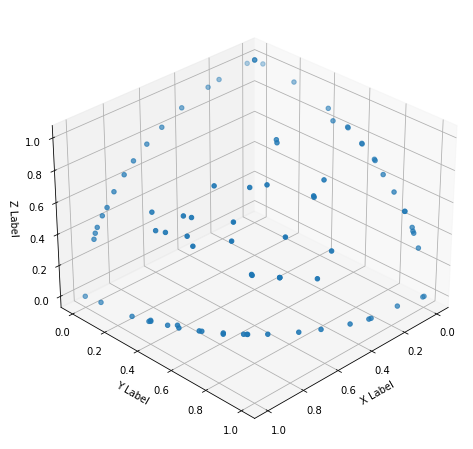

In [71]:
# run ibea
# step 0. Let's start with rough approx
ib = IBEA(problem, population_size=50, n_iterations=10, n_gen_per_iter=100,total_function_evaluations=5000)
while ib.continue_evolution():
    ib.iterate()
individuals, objective_values = ib.end()
print(ib.population.problem.ideal)
# show some of the ibea pop somehow
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(30,45)
ax.scatter(objective_values[:,0],objective_values[:,1],objective_values[:,2], label="IBEA Front")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()
# need to get the population
ini_pop = ib.population 

## PBEA

In [72]:
delta = 0.1
evolver = PBEA(problem, interact=True, population_size=50, initial_population=ini_pop, 
               n_iterations=10, n_gen_per_iter=100, total_function_evaluations=2000, 
               indicator=preference_indicator2, kappa=0.05, delta=delta)

## Give pref

In [73]:
# ask for preference
pref, plot = evolver.requests()
print(pref.content['message'])

Provide preference point. TODO add more info


In [74]:
responses = np.asarray([[0.3, 0.7, 0.45]])
#responses = np.asarray([[0.2, 0.8, 5.2]])
pref.response = pd.DataFrame([responses[0]], columns=pref.content['dimensions_data'].columns)
pref, plot = evolver.iterate(pref)

# show the best solution closest to the reference point
indx, obj = evolver.end()
dist, index = distance_to_reference_point(obj, responses[0])

print(f"Distance of best solution to the reference point: {dist}")
print(f"Values of best solution to the reference point: {obj[index]}")

message = (f"Current generation number:{evolver._current_gen_count}. "
           f"Is looping back recommended: {'Yes' if evolver.continue_evolution() else 'No'}"
           )
print(message)

Distance of best solution to the reference point: 0.08316093894134913
Values of best solution to the reference point: [0.38316094 0.77932607 0.49976016]
Current generation number:81. Is looping back recommended: No


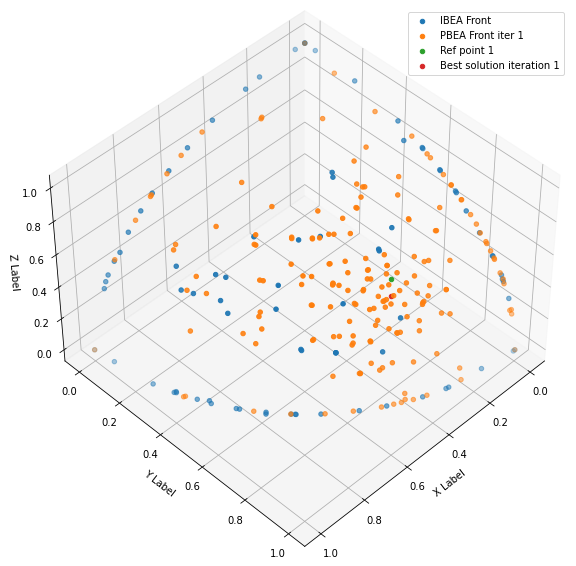

In [75]:
plt.rcParams['figure.figsize'] = [14, 10]

# should select small set of solutions to show to DM. For now we show all.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(45,45)
ax.scatter(objective_values[:,0],objective_values[:,1],objective_values[:,2], label="IBEA Front")
ax.scatter(obj_val[:,0], obj_val[:,1], obj_val[:,2], label="PBEA Front iter 1")
ax.scatter(responses[0][0], responses[0][1], responses[0][2], label="Ref point 1")
ax.scatter(obj[index][0], obj[index][1], obj[index][2], label="Best solution iteration 1")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.set_zlim(0,5)
ax.legend()
plt.show()

## give more pref

In [76]:
evolver.delta = 0.01
pref, plot = evolver.requests()
print(pref.content['message'])

Provide preference point. TODO add more info


In [77]:
responses = np.asarray([[0.1, 0.1, 0.95]])
#responses = np.asarray([[0.2, 0.8, .2]]) # too good b4
#responses = np.asarray([[0.1, 0.8, 4.2]])
pref.response = pd.DataFrame([responses[0]], columns=pref.content['dimensions_data'].columns)
pref, plot = evolver.iterate(pref)

# show the best solution closest to the reference point
indx, obj = evolver.end()
dist, index = distance_to_reference_point(obj, responses[0])

print(f"Distance of best solution to the reference point: {dist}")
print(f"Values of best solution to the reference point: {obj[index]}")

message = (f"Current generation number:{evolver._current_gen_count}. "
           f"Is looping back recommended: {'Yes' if evolver.continue_evolution() else 'No'}"
           )
print(message)

Distance of best solution to the reference point: 0.03336229442756772
Values of best solution to the reference point: [0.12804294 0.13336229 0.98320353]
Current generation number:161. Is looping back recommended: No


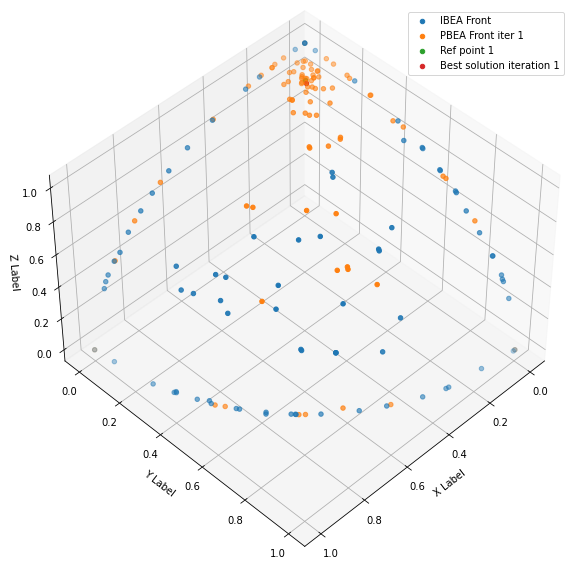

In [78]:
# should select small set of solutions to show to DM. For now we show all.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(45,45)
ax.scatter(objective_values[:,0],objective_values[:,1],objective_values[:,2], label="IBEA Front")
ax.scatter(obj[:,0], obj[:,1], obj[:,2], label="PBEA Front iter 1")
ax.scatter(responses[0][0], responses[0][1], responses[0][2], label="Ref point 1")
ax.scatter(obj[index][0], obj[index][1], obj[index][2], label="Best solution iteration 1")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()
plt.show()